# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [85]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Added by me for the purpose of this project
from ast import literal_eval

from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

#### Load the files and then display sizes + first rows

In [86]:
RAW_AZDIAS_FILENAME = 'Udacity_AZDIAS_Subset.csv'
RAW_FEAT_SUMMARY_FILENAME = 'AZDIAS_Feature_Summary.csv'
RAW_CUSTOMERS_FILENAME = 'Udacity_CUSTOMERS_Subset.csv'

# Load in the general demographics data.
azdias = pd.read_csv(RAW_AZDIAS_FILENAME, sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv(RAW_FEAT_SUMMARY_FILENAME, sep=';')
# Check the structure of the data after it's loaded
print("{} shape is {}".format(RAW_AZDIAS_FILENAME, azdias.shape))
print("{} shape is {}".format(RAW_FEAT_SUMMARY_FILENAME, feat_info.shape))

NB_ROWS_RAW_AZDIAS = azdias.shape[0]

Udacity_AZDIAS_Subset.csv shape is (891221, 85)
AZDIAS_Feature_Summary.csv shape is (85, 4)


In [87]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [88]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


***Observations:*** it seems this _`feature info`_ dataset must be used to get more informations on type of each feature (85 overall) and their value in the dataset in case it was missing. For example, `AGER_TYP` with a -1 or 0 value means that this value is actually a missing one => so deal with it.  
We have also informations about the type, `AGER_TYP` being categorical means each value corresponds to a specific category (we will have to decide later if one-hot encoding will be needed).

In [89]:
# Let's display few statistics elements
azdias.describe(include='all')

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000


---
## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [90]:
# Before performing transformation, are there columns with missing values ? How many ? Which ones ?
missing_lst = azdias.isna().sum().sort_values(ascending=False)
missing_lst

KK_KUNDENTYP             584612
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_BAUMAX             133324
KBA05_GBZ                133324
MOBI_REGIO               133324
REGIOTYP                 121196
KKK                      121196
PLZ8_ANTG3               116515
PLZ8_ANTG1               116515
PLZ8_GBZ                 116515
PLZ8_ANTG2               116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
W_KEIT_KIND_HH           107602
KBA13_ANZAHL_PKW         105800
CAMEO_INTL_2015           98979
CAMEO_DEU_2015            98979
CAMEO_DEUG_2015           98979
ORTSGR_KLS9               97216
ARBEIT                    97216
RELAT_AB                  97216
ANZ_HH_TITEL              97008
BALLRAUM                  93740
EWDICHTE                  93740
INNENSTADT                93740
GEBAEUDETYP_RASTER        93155
                          ...  
FINANZ_H

Ouch, there are a lot ! Let's try to see how many features actually contains missing values:

In [91]:
# How many columns contains missing values ?
missing_nb = len([x for x in missing_lst if x > 0])
print("There are {} columns that contains missing values in the row file {}".format(missing_nb, RAW_AZDIAS_FILENAME))

There are 53 columns that contains missing values in the row file Udacity_AZDIAS_Subset.csv


For some columns, there is a clear pattern:
* columns where name starts with `KBA05` contains 133324 missing values
* columns where name starts with `PLZ8` contains 116515 missing values
* columns where name starts with `CAMEO` contains 98979 missing values  
etc...

***Note:*** there are 584612 missing values for the column named `'KK_KUNDENTYP'`, it represents 65.6% of the number of samples, almost 2/3. It makes sense as per the dictionnary definition it is related to _"Consumer pattern over past 12 months"_ and not all people are customers I guess.

#### Identify missing or unknown data values and convert them to NaNs.
First step: display values in the `'missing_or_unknown'` column to see their type/distribution and see if it will be possible to rebuild the original python list object by using [`literal_eval`](https://docs.python.org/3/library/ast.html#ast.literal_eval) method from `ast` package

In [92]:
feat_info['missing_or_unknown']

0       [-1,0]
1     [-1,0,9]
2       [-1,0]
3          [0]
4         [-1]
5         [-1]
6         [-1]
7         [-1]
8         [-1]
9         [-1]
10        [-1]
11         [0]
12          []
13          []
14      [-1,0]
15         [0]
16         [0]
17         [0]
18         [0]
19         [0]
20         [0]
21      [-1,0]
22      [-1,0]
23         [0]
24      [-1,9]
25      [-1,9]
26      [-1,9]
27      [-1,9]
28      [-1,9]
29      [-1,9]
        ...   
55        [-1]
56        [-1]
57      [-1,X]
58        [XX]
59     [-1,XX]
60        [-1]
61        [-1]
62        [-1]
63        [-1]
64      [-1,0]
65      [-1,0]
66        [-1]
67        [-1]
68        [-1]
69          []
70      [-1,0]
71          []
72          []
73      [-1,0]
74          []
75        [-1]
76        [-1]
77        [-1]
78        [-1]
79      [-1,0]
80        [-1]
81        [-1]
82      [-1,9]
83      [-1,0]
84      [-1,9]
Name: missing_or_unknown, Length: 85, dtype: object

In [93]:
# Hummm, this specific one will fail as the X character is not surrounded by quotes (so cannot be considered as a string)
feat_info['missing_or_unknown'].iloc[57]

'[-1,X]'

##### ==> Let's replace non string X with 'X'

In [94]:
# We need to use regex=True to use regex and replace inplace.
# The first expression is a positive-lookbehind + positive look-ahead to be sure to replace one and only one occurrence of X per 'X'
# Otherwise the double XX would also be replaced by 'X''X' and that's definitely not what we expect
feat_info['missing_or_unknown'].replace('(?<=[^X])X(?=[^X])', "'X'", inplace=True, regex=True)
feat_info['missing_or_unknown'].replace('X{2}', "'XX'", inplace=True, regex=True)
feat_info.loc[feat_info.missing_or_unknown.str.find('X') > -1, 'missing_or_unknown']

57     [-1,'X']
58       ['XX']
59    [-1,'XX']
Name: missing_or_unknown, dtype: object

In [95]:
# Now we can rebuild the 'missing_or_unknown' column to the original list object by using literal_eval
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda x: literal_eval(x))

In [96]:
feat_info['missing_or_unknown'].iloc[57]

[-1, 'X']

##### Seems OK now, so lets' replace missing values with numpy 'Nan' into our dataset

In [97]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


***Note:*** _BEFORE APPLYING_ NaN transformation, let's do a specific check for columns with 'X' to replace with NaN. We'll then be able to check if it worked as expected.

In [98]:
azdias[azdias['CAMEO_DEUG_2015'].str.find('X') > -1]['CAMEO_DEUG_2015'].head(3)

2511    X
4569    X
9803    X
Name: CAMEO_DEUG_2015, dtype: object

OK, let's keep that in mind. Now we can iterate over all columns and, for each one, apply the "NaN transformation" for all values that should be converted.

In [99]:
# We will now work on a preprocessing copy of the original dataset so that we can still be able to compare
azdias_pp = azdias.copy()

In [100]:
def replace_missing_with_NaN(df, df_feat_info):
    """
    Replace missing values with numpy NaN in the given df. Values to transform are retrieved from the 'attribute' column
    of the second dataset (df_feat_info)
    :parameter df: (pandas Dataframe) the dataset to transform
    :parameter df_feat_info: (pandas Dataframe) the dataset to use to retrieve each value to change into numpy NaN
    :return: (pandas Dataframe) the dataset transformed
    """
    for col in feat_info['attribute']:
        nan_values = feat_info[feat_info['attribute'] == col]['missing_or_unknown'].tolist()[0]
        df[col] = df[col].apply(lambda x: np.NaN if x in nan_values else x)
    return df

In [101]:
%%time
azdias_pp = replace_missing_with_NaN(azdias_pp, feat_info)

CPU times: user 32.9 s, sys: 1.7 s, total: 34.6 s
Wall time: 34.7 s


##### ==> Sanity check before/after (with previously found values that should now be converted to NaN)

In [102]:
azdias.iloc[2511]['CAMEO_DEUG_2015']

'X'

In [103]:
azdias_pp.iloc[2511]['CAMEO_DEUG_2015']

nan

So far so good, it seems it worked, let's display more globally and then we will compare our new dataset with previously found NaN values (before the preprocessing).

In [104]:
azdias_pp.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


---
#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

##### After having replaced missing values with numpy NaN, check the new amount of missing data and compare to previous results

In [105]:
nb_nan_overall = azdias_pp.isna().sum().sort_values(ascending=False)
nb_nan_overall

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

In [106]:
missing_nb_after = len([x for x in nb_nan_overall.tolist() if x > 0]) 
missing_nb_after - missing_nb

8

Okay, there are some new columns (8). Pay attention to those 2 new columns with a high number of missing values (`TITEL_KZ` and `AGER_TYP`).  
As previously said, there is a clear pattern:
* columns where name starts with `KBA05` contains **133324** missing values
* columns where name starts with `PLZ8` contains **116515** missing values
* `HEALTH_TYP`, `SHOPPER_TYP`, `VERS_TYP` contains **111196** missing values
* columns where name starts with `CAMEO` contains **99352** missing values (note that it is more than before as we have added new NaN values)
* `BALLRAUM`, `EWDICHTE` and `INNENSTADT` contains **93740** missing values
* `GEBAEUDETYP`, `MIN_GEBAEUDEJAHR`, `WOHNLAGE` and `OST_WEST_KZ` contains **93148** missing values 
* `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` contains **77792** missing values
* `SOHO_KZ`, `ANZ_PERSONEN`, `WOHNDAUER_2008` and `ANZ_TITEL` contains **73499** missing values
* `CJT_GESAMTTYP`, `GFK_URLAUBERTYP`, `LP_STATUS_FEIN`, `LP_STATUS_GROB`, `RETOURTYP_BK_S` and `ONLINE_AFFINITAET` contains **4854** missing values

In [107]:
# Let's put that in a Dataframe if we want to use it later
stats_missing_df = nb_nan_overall.reset_index()
stats_missing_df.columns = ['attribute', 'nb_missing']
stats_missing_df['percentage_missing'] = stats_missing_df['nb_missing'].apply(lambda x: x/NB_ROWS_RAW_AZDIAS)
stats_missing_df.head(8)

,attribute,nb_missing,percentage_missing
0,TITEL_KZ,889061,0.997576
1,AGER_TYP,685843,0.769554
2,KK_KUNDENTYP,584612,0.655967
3,KBA05_BAUMAX,476524,0.534687
4,GEBURTSJAHR,392318,0.440203
5,ALTER_HH,310267,0.348137
6,REGIOTYP,158064,0.177357
7,KKK,158064,0.177357


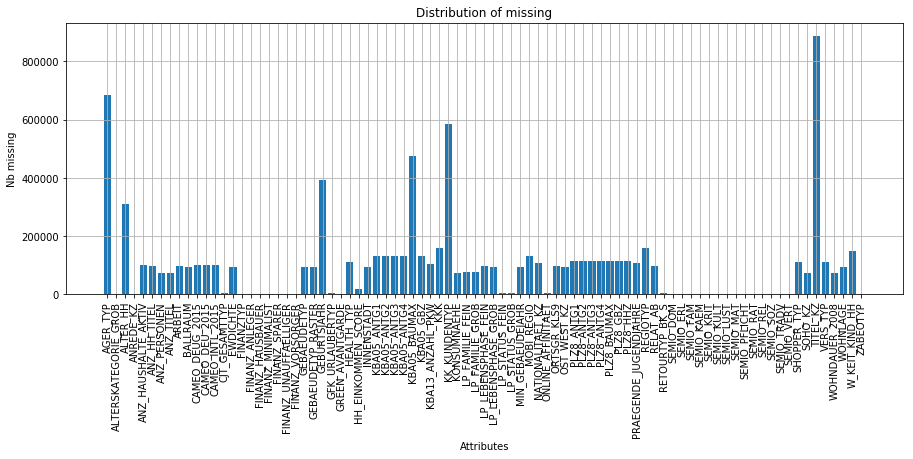

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.bar(stats_missing_df['attribute'], stats_missing_df['nb_missing'])
plt.xlabel('Attributes')
plt.xticks(rotation=90)
plt.ylabel('Nb missing')
plt.title('Distribution of missing')
plt.grid(True)
plt.show()

#####  Based on dictionnary file, investigation on patterns in the amount of missing data in each column:
* columns where name starts with `KBA05` contains **133324** missing values  
They are all related to 'family houses' so it makes sense that the number of missing values is the same  
==> when the information is not known for one feature it is not known for the others that belongs to this 'category'.


* columns where name starts with `PLZ8` contains **116515** missing values  
It is also related to 'family houses', that might explain why the amount of missing values is almost the same as for `KBA05`.

In [109]:
# 133324 missing for: KBA05_ANTG4, KBA05_GBZ, MOBI_REGIO, KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3
# When one 'KBA05_xxx' column is null, others KBA05 are as well
azdias_pp[(azdias_pp['KBA05_ANTG4'].isnull())][['KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1', 
                                                'KBA05_ANTG2', 'KBA05_ANTG3']].isna().sum()

KBA05_ANTG4    133324
KBA05_GBZ      133324
MOBI_REGIO     133324
KBA05_ANTG1    133324
KBA05_ANTG2    133324
KBA05_ANTG3    133324
dtype: int64

In [110]:
# 116515 missing for: PLZ8_GBZ, PLZ8_HHZ, PLZ8_BAUMAX, PLZ8_ANTG4, PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG2
# When one 'PLZ8_xxx' column is null, others PLZ8 are as well
azdias_pp[(azdias_pp['PLZ8_GBZ'].isnull())][['PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1', 
                                            'PLZ8_ANTG3', 'PLZ8_ANTG2']].isna().sum()

PLZ8_GBZ       116515
PLZ8_HHZ       116515
PLZ8_BAUMAX    116515
PLZ8_ANTG4     116515
PLZ8_ANTG1     116515
PLZ8_ANTG3     116515
PLZ8_ANTG2     116515
dtype: int64

In [111]:
# 133324 missing for: KBA05_ANTG4, KBA05_GBZ, MOBI_REGIO, KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3
# 116515 missing for: PLZ8_GBZ, PLZ8_HHZ, PLZ8_BAUMAX, PLZ8_ANTG4, PLZ8_ANTG1, PLZ8_ANTG3, PLZ8_ANTG2
azdias_pp[(azdias_pp['KBA05_ANTG4'].isnull())]['PLZ8_GBZ'].isna().sum()

107066

***Note:*** the major part of rows with missing value on `PLZ8` columns has also missing value for `KBA05` columns: 107066 over 116515 (~92%)

* `HEALTH_TYP`, `SHOPPER_TYP`, `VERS_TYP` contains **111196** missing values  
Respectively:
    * Health typology
    * Shopper typology
    * Insurance typology  
==> Check if all are the same people

In [112]:
print(azdias_pp[(azdias_pp['HEALTH_TYP'].isnull())]['SHOPPER_TYP'].isna().sum())
print(azdias_pp[(azdias_pp['HEALTH_TYP'].isnull())]['VERS_TYP'].isna().sum())
print(azdias_pp[(azdias_pp['SHOPPER_TYP'].isnull())]['VERS_TYP'].isna().sum())

111196
111196
111196


***Note:*** we can confirm that when one value in null for one of those 3 columns, it is also null on the 2 others.

* columns where name starts with `CAMEO` contains **99352** missing values (note that it is more than before as we have added new NaN values)  
All related to 'Wealth / Life Stage Typology' with different scale for the same information, that's why missing values are the same  
==> when you don't have for one you don't have for the others.


* `BALLRAUM`, `EWDICHTE` and `INNENSTADT` contains **93740** missing values  
All 'postcode-level' features. Respectively:
    * Distance to nearest urban center
    * Density of households per square kilometer
    * Distance to city center (downtown)  
    ==> Same remark: once you have the value for one feature, you can guess/compute value for the 2 others.


* `GEBAEUDETYP`, `MIN_GEBAEUDEJAHR`, `WOHNLAGE` and `OST_WEST_KZ` contains **93148** missing values  
Respectively:  
    * Ratio of residential to commercial activity
    * First year building was mentioned in the database
    * Neighborhood quality (or rural flag)
    * Building location via former East / West Germany (GDR / FRG)  
==> I am not sure there is a link between those features, we will check that missing values are always for same samples.

In [113]:
print(azdias_pp[(azdias_pp['GEBAEUDETYP'].isnull())][['MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'OST_WEST_KZ']].isna().sum())

MIN_GEBAEUDEJAHR    93148
WOHNLAGE            93148
OST_WEST_KZ         93148
dtype: int64


***Note:*** we can confirm that when one value in null for one of those 4 columns, it is also null on the 3 others.

* `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` contains **77792** missing values  
Related to 'Family type' put on 2 different scales.


* `SOHO_KZ`, `ANZ_PERSONEN`, `WOHNDAUER_2008` and `ANZ_TITEL` contains **73499** missing values  
Respectively:  
    * Small office / home office flag
    * Number of adults in household
    * Length of residence
    * Number of professional academic title holders in household  
==> Also to check whether missing values are linked to same samples.

In [114]:
print(azdias_pp[(azdias_pp['SOHO_KZ'].isnull())][['ANZ_PERSONEN', 'WOHNDAUER_2008', 'ANZ_TITEL']].isna().sum())

ANZ_PERSONEN      73499
WOHNDAUER_2008    73499
ANZ_TITEL         73499
dtype: int64


***Note:*** we can confirm that when one value in null for one of those 4 columns, it is also null on the 3 others.

* `CJT_GESAMTTYP`, `GFK_URLAUBERTYP`, `LP_STATUS_FEIN`, `LP_STATUS_GROB`, `RETOURTYP_BK_S` and `ONLINE_AFFINITAET` contains **4854** missing values  
Respectively:  
    * Customer-Journey-Typology
    * Vacation habits
    * Social status in both fine and rough scale
    * Return type
    * Online affinity  
==> We could say that those features seems to be related to 'customer habits'

#### Deal with outliers columns
Let's first remember what are the columns with highest number of missing values:

In [115]:
stats_missing_df.head(8)

,attribute,nb_missing,percentage_missing
0,TITEL_KZ,889061,0.997576
1,AGER_TYP,685843,0.769554
2,KK_KUNDENTYP,584612,0.655967
3,KBA05_BAUMAX,476524,0.534687
4,GEBURTSJAHR,392318,0.440203
5,ALTER_HH,310267,0.348137
6,REGIOTYP,158064,0.177357
7,KKK,158064,0.177357


In [116]:
# Remove the outlier columns from the dataset where there is more than 200K missing values
cols_to_del = stats_missing_df[stats_missing_df['nb_missing'] > 200000].attribute.tolist()
cols_to_del

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [117]:
azdias_pp = azdias_pp.drop(cols_to_del, axis=1)
# Sanity check: there should be 6 columns less so 79
azdias_pp.shape

(891221, 79)

---
#### Discussion 1.1.2: Assess Missing Data in Each Column
As seen earlier with the graph, we have 6 columns that contains more than 200K (which represents a little bit more than 20% of the samples) missing values:
* `TITEL_KZ`: Academic title flag, almost never known (perhaps because few people are eligible to this title...)
* `AGER_TYP`: Best-ager typology, 77% unknown
* `KK_KUNDENTYP`: Consumer pattern over past 12 months, , 66% unknown
* `KBA05_BAUMAX`: Most common building type within the microcell, 53% unknown
* `GEBURTSJAHR`: Year of birth, 44% unknown
* `ALTER_HH`: Birthdate of head of household, 34% unknown

Those columns have been removed.  
We have also discovered some relationships between columns in the dataset regarding missing values. This totally makes sense because some features are based on the same raw data put on a different scale, for example `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB` columns.  
Sometimes there are a lot of missing values related to one 'topic', it probably means that this information could not be collected for this person so all features related to this group are set to 'NaN'. This is something that we will analyze more deeply in the next section.  
Anyway, this first observation has shown that there is clearly something to do to reduce the number of features because the information is sometimes redundant.

---

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [118]:
# How much data is missing in each row of the dataset?
nb_missing_per_row = azdias_pp.isnull().sum(axis=1).sort_values(ascending=False)
azdias_pp['nb_missing_in_row'] = nb_missing_per_row
nb_missing_per_row

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

***Note:*** we can have rows with 49 NaN values (over 79 !). Let's see how many rows per nb of missing values we have:

In [119]:
# Uncomment the cell below to get the number of rows per "nb missing values in row"
# azdias_pp.groupby('nb_missing_in_row').nb_missing_in_row.count()#.sort_values(ascending=False)

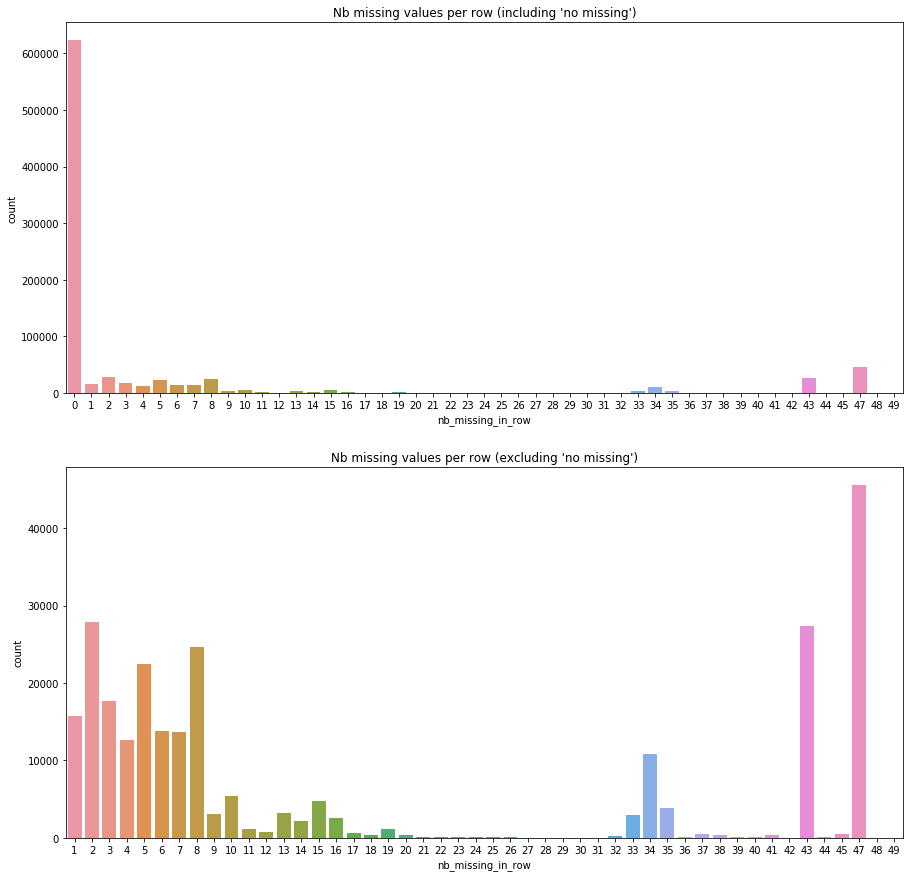

In [120]:
# Let's plot that to have a better understanding
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].set_title("Nb missing values per row (including 'no missing')")
ax[1].set_title("Nb missing values per row (excluding 'no missing')")
sns.countplot(x='nb_missing_in_row', data=azdias_pp, ax=ax[0])
sns.countplot(x='nb_missing_in_row', data=azdias_pp[azdias_pp['nb_missing_in_row'] > 0], ax=ax[1])
plt.show()

In [121]:
nb_rows = azdias.shape[0]
def count_rows_under_limit(df, nb_rows, limit):
    nb_limit = df[df['nb_missing_in_row'] <= limit].nb_missing_in_row.count()
    print("{:.2f}% of the dataset is kept if the limit is set to {}".format(100 * (nb_limit/nb_rows), limit))

In [122]:
count_rows_under_limit(azdias_pp, nb_rows, limit=0)
count_rows_under_limit(azdias_pp, nb_rows, limit=8)
count_rows_under_limit(azdias_pp, nb_rows, limit=26)

69.93% of the dataset is kept if the limit is set to 0
86.59% of the dataset is kept if the limit is set to 8
89.54% of the dataset is kept if the limit is set to 26


***Note:*** the major part of the rows have no missing values (623209 over 891211 ~= 70%). It is almost 87% by taking all rows that have at most 8 missing values. Let's try this treshold value.

In [123]:
# Write code to divide the data into two subsets based on the number of missing
treshold = 8
azdias_pp_subset1 = azdias_pp[azdias_pp['nb_missing_in_row'] <= treshold]
azdias_pp_subset2 = azdias_pp[azdias_pp['nb_missing_in_row'] > treshold]
# Sanity check
print(azdias_pp_subset1.shape)
print(azdias_pp_subset2.shape)

(771701, 80)
(119520, 80)


#### Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

In [124]:
# Uncomment & comment one of the above lines to display the names of columns without missing values for each subset
# azdias_pp_subset1.isna().sum().sort_values()
# azdias_pp_subset2.isna().sum().sort_values()

In [125]:
def plot_dist_comparison(col_list, subset1, subset2):
    """
    Display plots about values distribution in both given subsets for each column in the given list
    :parameter col_list: (list) a list of dataframe columns that will be analyzed
    :parameter subset1: (pandas Dataframe) first subset to analyze (the one with no or few missing values)
    :parameter subset2: (pandas Dataframe) the other subset (the one with more missing values)
    """
    fig, ax = plt.subplots(len(col_list), 2, figsize=(15, len(col_list)*6))
    for i, col in enumerate(col_list):
        ax[i][0].set_title("Column {} in subset with few missing values".format(col))
        ax[i][1].set_title("Column {} in subset with more missing values".format(col))
        sns.countplot(x=col, data=subset1, ax=ax[i][0])
        sns.countplot(x=col, data=subset2, ax=ax[i][1])
    plt.show()

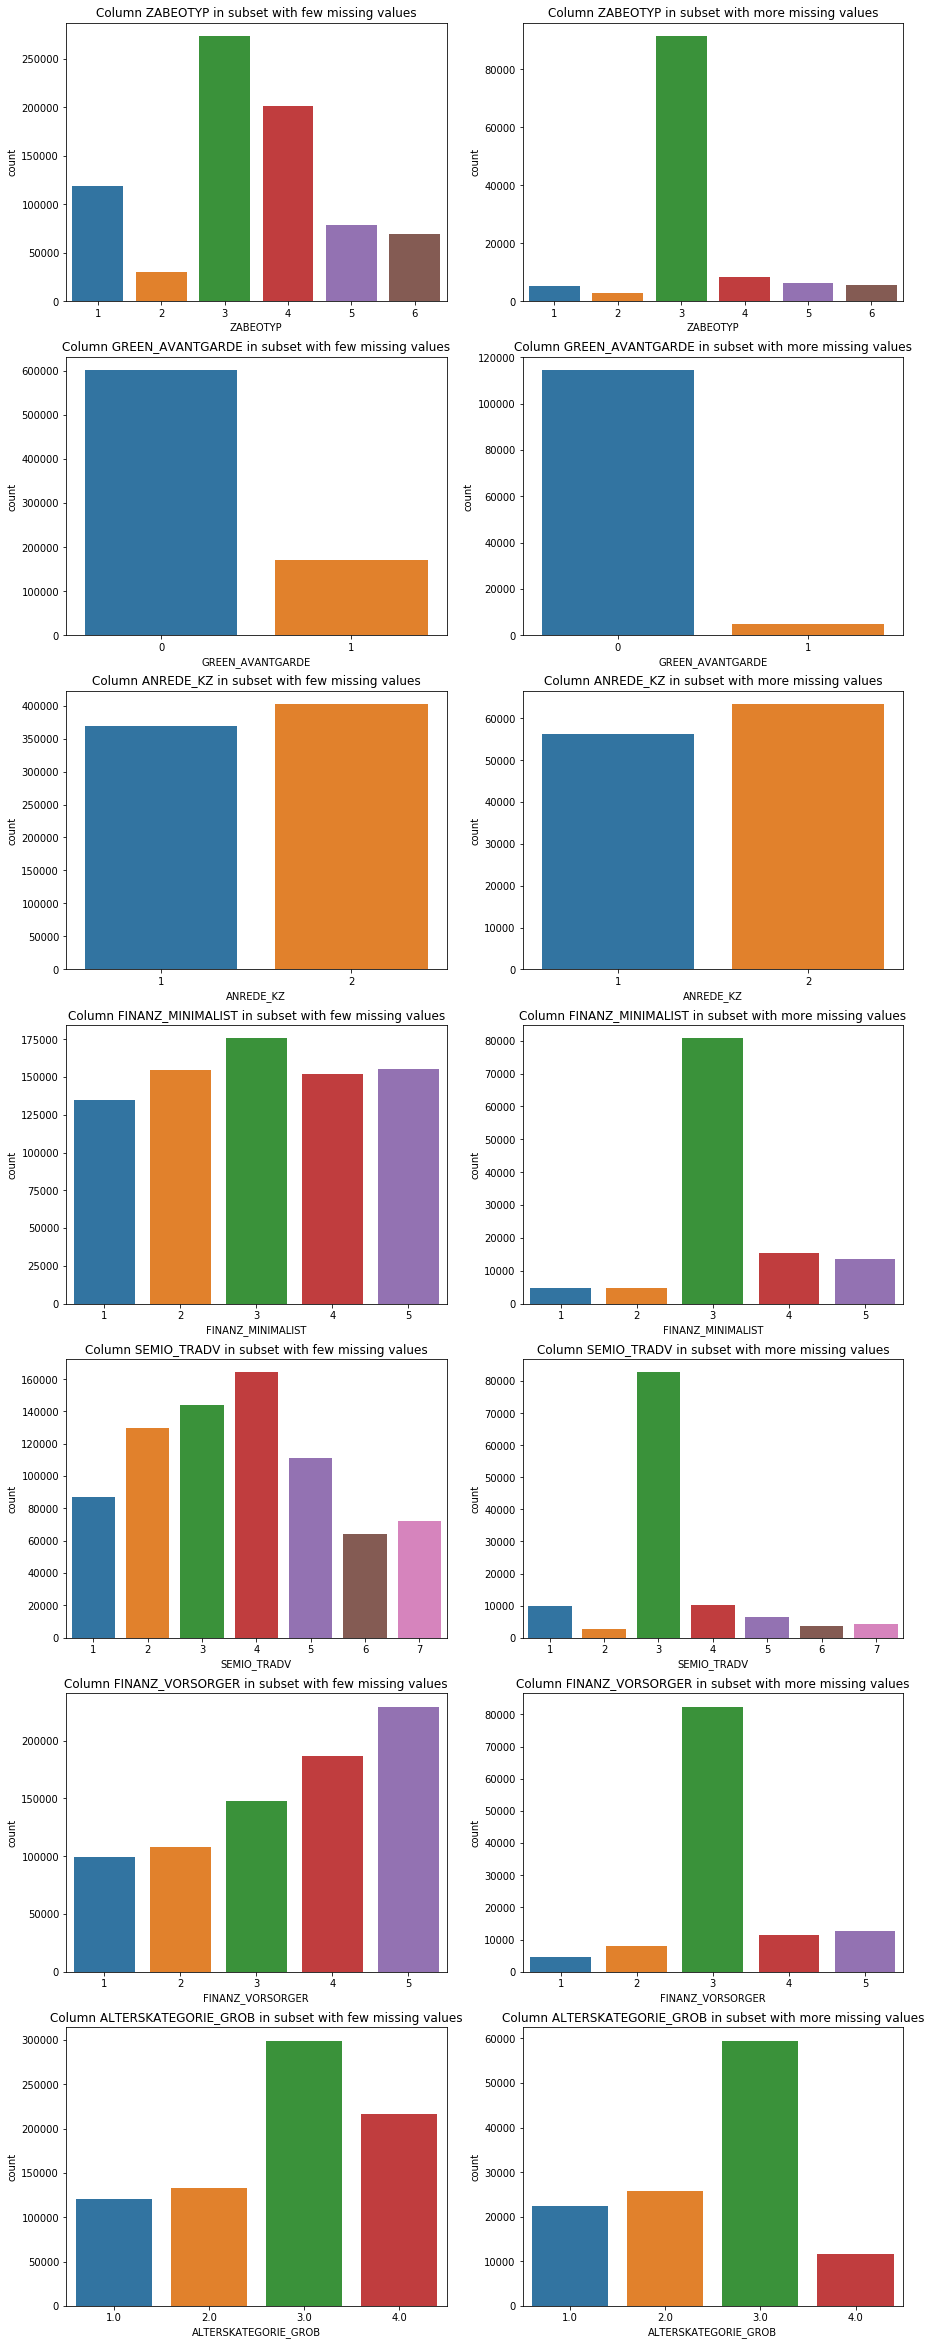

In [128]:
col_list = ['ZABEOTYP', 'GREEN_AVANTGARDE', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'SEMIO_TRADV', 'FINANZ_VORSORGER', 'ALTERSKATEGORIE_GROB']
plot_dist_comparison(col_list, azdias_pp_subset1, azdias_pp_subset2)

---
#### Discussion 1.1.3: Assess Missing Data in Each Row
I have decided to split the whole dataset into 2 subsets with 8 as the treshold value. This treshold corresponds to the maximum number of missing values allowed per row. It remains an acceptable choice because:
* With such a value, 87% of the dataset is kept in the first subset, all other rows going into the second subset (and we do not want to keep too few samples in our dataset so it seems to be a good trade-off)
* 8 is still a low value in comparison to the maximum (49) or even 20

Once this is done, we can see on above plots (**/!\ be careful at the scale which is not the same between plots on the left than on the right**) that the data with many missing values looks different from the data with few or no missing values. Few columns have been 'randomly' picked among the list of columns that have no or few missing values in both subsets:
* `ZABEOTYP`: Energy consumption typology (mostly 'fair supplied' in subset n°2)
* `GREEN_AVANTGARDE`: Membership in environmental sustainability as part of youth (not a lot of member in subset n°2)
* `ANREDE_KZ`: Gender, almost the same distribution in both subsets
* `FINANZ_MINIMALIST`: Financial typology 'minimalist' section, mostly 'average' in subset n°2
* `FINANZ_VORSORGER`: Financial typology 'be prepared' section, mostly 'average' in subset n°2
* `SEMIO_TRADV`: Personality typology, mostly 'high affinity with tradional-minded' in subset n°2
* `ALTERSKATEGORIE_GROB`: Estimated age, '46 - 60 years old' is the highest i subset n°2 like in subset n°1 but distribution is different (fewer old people for example).  

Order is even sometimes different (meaning that the most frequent value on dataset with few or no missing value is not the same as in the other dataset). Apart from one of them (`ANREDE_KZ`) we can see that the distribution is slightly different so that would be too dangerous to just get rid of this subset.

---

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [160]:
# How many features are there of each data type?
feat_info.groupby('type').type.count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: type, dtype: int64

In [161]:
# Let's see what are the features with 'mixed' or 'categorical' type
feat_info[(feat_info['type'] == 'mixed') | (feat_info['type'] == 'categorical')]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [162]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info['type'] == 'categorical'].attribute.tolist()

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

***Note:*** remember that earlier we have decided to get rid of those 6 features: 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH' so they will not appear in this table.

| Column | Description | Type | Decision |
| --- | --- | --- | --- |
| ANREDE_KZ | Gender | Binary | Keep |
| SOHO_KZ | Small office / home office flag | Binary | Keep |
| VERS_TYP | Insurance typology | Binary | Keep, re-encode as 0/1 |
| GREEN_AVANTGARDE | Membership in environmental sustainability | Binary | Keep |
| OST_WEST_KZ | Building location via former East / West Germany (GDR / FRG) | Binary (but not numeric !) | Keep, re-encode as 0/1 |
| CJT_GESAMTTYP | Preferred information and buying channels for consumer | Multi-level (1 to 6) | Keep & 1-hot encode |
| FINANZTYP | Most descriptive financial type for individual | Multi-level (1 to 6) | Keep & 1-hot encode |
| GFK_URLAUBERTYP | Vacation habits | Multi-level (1 to 12) | Keep & 1-hot encode |
| LP_FAMILIE_FEIN | Family type, fine scale | Multi-level (1 to 11) | Drop, data already included in rough scale |
| LP_FAMILIE_GROB | Family type, rough scale | Multi-level (1 to 5) | Keep & 1-hot encode |
| LP_STATUS_FEIN | Social status, fine scale | Multi-level (1 to 10) | Drop, data already included in rough scale |
| LP_STATUS_GROB | Social status, rough scale | Multi-level (1 to 5) | Keep & 1-hot encode |
| NATIONALITAET_KZ | Nationality based on given name analysis | Multi-level (1 to 3) | Keep & 1-hot encode |
| SHOPPER_TYP | Shopper typology | Multi-level (1 to 3) | Keep & 1-hot encode |
| ZABEOTYP | Energy consumption typology | Multi-level (1 to 9) | Keep & 1-hot encode |
| GEBAEUDETYP | Type of building (residential vs. commercial) | Multi-level (1 to 8) | Keep & 1-hot encode |
| CAMEO_DEUG_2015 | German CAMEO: Wealth / Life Stage Typology, rough scale | Multi-level (1 to 9) | Keep & 1-hot encode |
| CAMEO_DEU_2015 | German CAMEO: Wealth / Life Stage Typology, detailed scale | Multi-level (not numeric !) | Drop, data already included in rough scale |

In [163]:
# Drop section
cols_to_del_2 = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'nb_missing_in_row']
azdias_pp_subset1 = azdias_pp_subset1.drop(cols_to_del_2, axis=1)
azdias_pp_subset1.shape

(771701, 76)

In [164]:
# Re-encode binary as 0/1
azdias_pp_subset1['VERS_TYP'] = azdias_pp_subset1['VERS_TYP'].apply(lambda x: 1 if x == 2 else 0 if x == 1 else x)
azdias_pp_subset1['OST_WEST_KZ'] = azdias_pp_subset1['OST_WEST_KZ'].apply(lambda x: 1 if x == 'O' else 0 if x == 'W' else x)

In [165]:
# Re-encode categorical variable(s) to be kept in the analysis.
def encode_categorical(df, one_hot_encode_col_list):
    """
    Transform the given dataset by creating dummy variables for each column in the given list
    :parameter df: (pandas Dataframe) the dataframe to transform
    :parameter one_hot_encode_col_list: (list) all columns to one-hot encode
    :return: (pandas Dataframe) the given dataframe transformed
    """
    for col in one_hot_encode_col_list:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
    
    # Do not forget to remove the original columns as they are not needed anymore
    df = df.drop(one_hot_encode_col_list, axis=1)
    return df

In [166]:
one_hot_encode_col_list = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                           'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
azdias_pp_subset1 = encode_categorical(azdias_pp_subset1, one_hot_encode_col_list)
print("Shape is now: {}".format(azdias_pp_subset1.shape))

Shape is now: (771701, 129)


In [50]:
azdias_pp_subset1.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,0,0,1,0


---
#### Discussion 1.2.1: Re-Encode Categorical Features

There were some categorical features that have already been deleted with previous analysis (for example `TITEL_KZ`, `AGER_TYP`). All others have been analyzed one by one and you can see the decision made for each one in the table above.  
Basically:
* all binary features have been kept as the effort is small (pay attention though to the `OST_WEST_KZ` column wich is binary but not numeric => re-encoded as 0/1 with an apply method)
* redundant features have been dropped when the information was already present: it is the case for some features where the same data is put on different scales. The simplest one has been kept.

---

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [51]:
feat_info[feat_info['type'] == 'mixed'].attribute.tolist()

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

Note that `KBA05_BAUMAX` has already been dropped as per previous analysis on missing values.

| Column | Description | Decision |
| --- | --- | --- |
| LP_LEBENSPHASE_FEIN | Life stage, fine scale | Drop, data already included in rough scale |
| LP_LEBENSPHASE_GROB | Life stage, rough scale | Drop also, seems to be a combination of some other features (age, income, etc) |
| PRAEGENDE_JUGENDJAHRE | generation by decade, movement (mainstream vs. avantgarde), and nation  | Keep, it is asked in the project to keep it |
| WOHNLAGE | Neighborhood quality (or rural flag) | Create an interval from _very good_ to _very poor_ for the neighborhood and another feature binary telling whether it is a new building or not in case the value is 8 |
| CAMEO_INTL_2015 | Wealth and life stage | Keep and deal with it |
| PLZ8_BAUMAX | Most common building type within the PLZ8 region (interval for family homes or business) | Drop, could be a combination of `PLZ8_GBZ` and `PLZ8_ANTGx` |

##### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
From Dictionnary.md we have:
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Goal: it contains generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west) ==> create two new variables to capture 2 dimensions: an interval-type variable for decade, and a binary variable for movement.

In [52]:
def engineer_praegende_jugendjarhe(df):
    """
    Handle the 'PRAEGENDE_JUGENDJAHRE' column by creating 2 new columns:
        'movement' which is binary (0 stands for mainstream movement, 1 for avantgarde)
        'decade' which is an interval from 1 to 6 for the decade (from 40s to 90s)
    :parameter df: (pandas Dataframe) the dataframe to transform
    :return: (pandas Dataframe) the dataframe transformed
    """
    mainstream_col_values = [1, 3, 5, 8, 10, 12, 14]
    interval_decade = {1: 1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6, 16:6}

    df["movement"] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in mainstream_col_values else 1 if str(x) != 'nan' else np.NaN)
    df["decade"] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: interval_decade[x] if str(x) != 'nan' else np.NaN)
    df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    return df

In [53]:
# Sanity check around the method call
print(azdias_pp_subset1[['PRAEGENDE_JUGENDJAHRE']].head(7))
azdias_pp_subset1 = engineer_praegende_jugendjarhe(azdias_pp_subset1)
print(azdias_pp_subset1[["movement", "decade"]].head(7))
print("Shape is now: {}".format(azdias_pp_subset1.shape))

   PRAEGENDE_JUGENDJAHRE
1                   14.0
2                   15.0
3                    8.0
4                    8.0
5                    3.0
6                   10.0
7                    8.0
   movement  decade
1       0.0     6.0
2       1.0     6.0
3       0.0     4.0
4       0.0     4.0
5       0.0     2.0
6       0.0     5.0
7       0.0     4.0
Shape is now: (771701, 130)


##### Investigate "CAMEO_INTL_2015" and engineer two new variables.
From Dictionnary.md we have:
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement

Goal: it contains wealth and life stage ==> Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [54]:
def engineer_cameo_intl(df):
    """
    Handle the 'CAMEO_INTL_2015' column by creating 2 new columns:
        'wealth' which is ordinal (1 to 5 - from Wealthy to Poorer Households)
        'lifestage' which is ordinal too (1 to 5)
    :parameter df: (pandas Dataframe) the dataframe to transform
    :return: (pandas Dataframe) the dataframe transformed
    """
    df["wealth"] = df['CAMEO_INTL_2015'].apply(lambda x: int(int(x)/10) if str(x) != 'nan' else np.NaN)
    df["lifestage"] = df['CAMEO_INTL_2015'].apply(lambda x: int(x)%10 if str(x) != 'nan' else np.NaN)
    df = df.drop(['CAMEO_INTL_2015'], axis=1)
    
    return df

In [55]:
# Sanity check around the method call
print(azdias_pp_subset1[['CAMEO_INTL_2015']].head(7))
azdias_pp_subset1 = engineer_cameo_intl(azdias_pp_subset1)
print(azdias_pp_subset1[["wealth", "lifestage"]].head(7))
print("Shape is now: {}".format(azdias_pp_subset1.shape))

  CAMEO_INTL_2015
1              51
2              24
3              12
4              43
5              54
6              22
7              14
   wealth  lifestage
1     5.0        1.0
2     2.0        4.0
3     1.0        2.0
4     4.0        3.0
5     5.0        4.0
6     2.0        2.0
7     1.0        4.0
Shape is now: (771701, 131)


##### Investigate "WOHNLAGE" and engineer two new variables.
From Dictionnary.md we have:
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood


In [56]:
def engineer_wohnlage(df):
    """
    Handle the 'WOHNLAGE' column by creating 2 new columns:
        'neighborhood' which is ordinal (1 to 7 - from very good to rural)
        'new_building' which is binary (1 if value is 8, all others goes to 0)
    :parameter df: (pandas Dataframe) the dataframe to transform
    :return: (pandas Dataframe) the dataframe transformed
    """
    df["neighborhood"] = df['WOHNLAGE'].apply(lambda x: 7 if x == 8 else x if str(x) != 'nan' else np.NaN)
    df["new_building"] = df['WOHNLAGE'].apply(lambda x: 1 if x == 8 else 0 if str(x) != 'nan' else np.NaN)
    df = df.drop(['WOHNLAGE'], axis=1)
    
    return df

In [57]:
# azdias_pp_subset1[['WOHNLAGE']].isna().sum() ==> 0
# azdias_pp_subset1[azdias_pp_subset1['WOHNLAGE'] == 8].shape[0] ==> 14405
# azdias_pp_subset1['WOHNLAGE'].sum() ==> 3134149

In [58]:
# Sanity check around the method call
print(azdias_pp_subset1[['WOHNLAGE']].head(7))
azdias_pp_subset1 = engineer_wohnlage(azdias_pp_subset1)
print(azdias_pp_subset1[["neighborhood", "new_building"]].head(7))
print("Shape is now: {}".format(azdias_pp_subset1.shape))

   WOHNLAGE
1       4.0
2       2.0
3       7.0
4       3.0
5       7.0
6       5.0
7       1.0
   neighborhood  new_building
1           4.0             0
2           2.0             0
3           7.0             0
4           3.0             0
5           7.0             0
6           5.0             0
7           1.0             0
Shape is now: (771701, 132)


In [59]:
# Sanity check
print(azdias_pp_subset1['new_building'].sum()) # Should print 14405 (same number as '8' values in the original column)
print(azdias_pp_subset1['neighborhood'].sum()) # Should print 3134149 - 14405 = 3119744 ('8' values are converted to '7' so it is the original value - the number of '8' values)

14405
3119744.0


In [60]:
# Do not forget to remove others mixed-type columns
mixedtype_to_delete = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']
azdias_pp_subset1 = azdias_pp_subset1.drop(mixedtype_to_delete, axis=1)
print("Shape is now: {}".format(azdias_pp_subset1.shape))

Shape is now: (771701, 129)


---
#### Discussion 1.2.2: Engineer Mixed-Type Features
Among the 6 mixed-type, columns, 3 are dropped because information seems to be redundant with other features we have (Life stage, fine and rough scales with `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROS` features + `PLZ8_BAUMAX`).  
The 3 others are kept and each column gets its own transformation process through _apply_ method overall the whole dataset:
* `PRAEGENDE_JUGENDJAHRE` is dropped and replaced by 2 new columns: _'decade'_ which holds the generation by decade information and _'movement'_ which is binary (0 for mainstream vs. 1 for avantgarde)
* `WOHNLAGE` is dropped and replaced by 2 new columns: _'neighborhood'_ which is ordinal (1 to 7 - from very good to rural) and _'new_building'_ which is binary (1 if value is 8, all others goes to 0)
* `CAMEO_INTL_2015` is dropped and replaced by 2 new columns: _'wealth'_ which is ordinal (1 to 5 - from Wealthy to Poorer Households) and _'lifestage'_ which is ordinal too (from 1 to 5)

---

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [61]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_cols_removed = feat_info[feat_info['type'] == 'mixed'].attribute.tolist()
for col in azdias_pp_subset1.columns:
    if col in mixed_cols_removed:
        print("Column {} should have been deleted !".format(col))
print("Check finished !")

Check finished !


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [174]:
def clean_data(df, feat_info, treshold, use_treshold=False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame + features_info DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df_clean = df.copy()

    # convert missing value codes into NaNs, ...
    df_clean = replace_missing_with_NaN(df_clean, feat_info)
    
    # remove selected columns and rows, ...
    cols_to_del = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df_clean = df_clean.drop(cols_to_del, axis=1)

    if use_treshold:
        df_clean['nb_missing_in_row'] = df_clean.isnull().sum(axis=1).sort_values(ascending=False)
        df_clean = df_clean[df_clean['nb_missing_in_row'] <= treshold]
        df_clean = df_clean.drop(['nb_missing_in_row'], axis=1)
        
    cols_to_del2 = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']
    df_clean = df_clean.drop(cols_to_del2, axis=1)

    # select, re-encode, and engineer column values.
    # Re-encode binary as 0/1
    df_clean['VERS_TYP'] = df_clean['VERS_TYP'].apply(lambda x: 1 if x == 2 else 0 if x == 1 else x)
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].apply(lambda x: 1 if x == 'O' else 0 if x == 'W' else x)

    # Handle features to 1-hot encode
    one_hot_encode_col_list = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                               'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
    df_clean = encode_categorical(df_clean, one_hot_encode_col_list)
    
    # Handle some mixed-type features
    df_clean = engineer_praegende_jugendjarhe(df_clean)
    df_clean = engineer_cameo_intl(df_clean)
    df_clean = engineer_wohnlage(df_clean)
    mixedtype_to_delete = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX']
    df_clean = df_clean.drop(mixedtype_to_delete, axis=1)
    
    # Return the cleaned dataframe.
    return df_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

#### If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.

In [176]:
%%time
# Check our cleaning method works fine (we should have 771701 rows and 129 columns in the end)
azdias_clean = clean_data(azdias, feat_info, treshold=8, use_treshold=True)
print(azdias_clean.shape)

(771701, 129)
CPU times: user 46.9 s, sys: 16.1 s, total: 1min 3s
Wall time: 1min 3s


In [178]:
# Uncomment this cell to display a list of columns that contains missing values
# azdias_clean.isna().sum().sort_values(ascending=False).reset_index().head(40)

Apart from `ANZ_HAUSHALTE_AKTIV, KBA13_ANZAHL_PKW, ANZ_HH_TITEL` which are _numeric_ all other columns are either _ordinal_ either _categorical_.

In [65]:
import sklearn
sklearn.__version__

'0.19.1'

In [179]:
# Apply feature scaling to the general population demographics data.
feat_imp = Imputer(missing_values="NaN", strategy="median") #give a try to 'most_frequent' also
azdias_imputed = feat_imp.fit_transform(azdias_clean)

feat_scaler = StandardScaler()
azdias_scaled = feat_scaler.fit_transform(azdias_imputed)

print(azdias_imputed.shape)
print(azdias_scaled.shape)

(771701, 129)
(771701, 129)


---
### Discussion 2.1: Apply Feature Scaling
First thing is to take care of missing values: we cannot just simply get rid of all samples that contains missing values because we have seen earlier that distribution of values in some columns are really different. We have already removed a lot by dropping all rows containing more than 8 missing values, removing any data point with missing value would introduce a bias in our work.

Note that with a more recent of sklearn I would have use [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer) to build a pipeline:
```
numeric_features = ['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW', 'ANZ_HH_TITEL']
cat_ord_features = [x for x in azdias_clean.columns if x not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_ord__transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())])

ct = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_ord__transformer, cat_ord_features)])
cf.fit_transform(azdias_clean)
```

Instead of that, with what I have at disposal in this version and to keep things easy I will go for `median` or `most_frequent` for all columns, no matter if they are numeric or categorical/ordinal. This will introduce a bias but it remains better than just dropping everything ang get huge data information loss.

---

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [180]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_scaled)

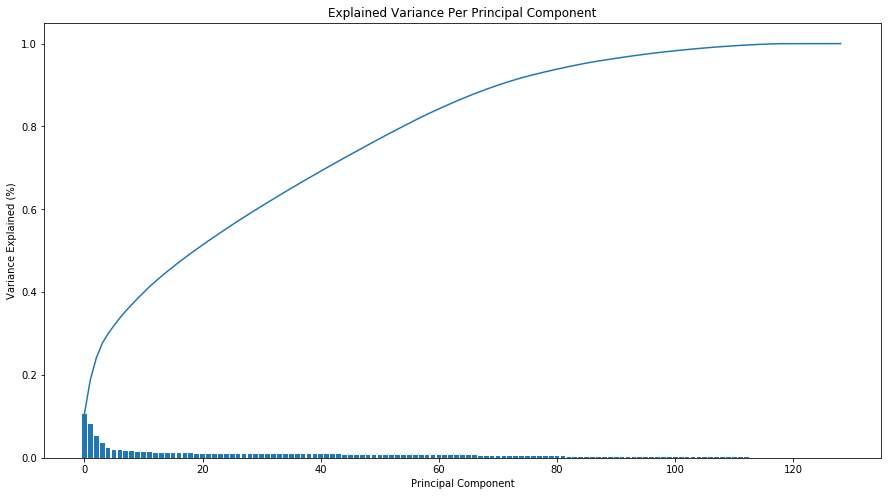

In [181]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components (copied from helper file in lessons)
    
    :parameter pca: (object) the result of PCA method call in scikit learn
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [183]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=80)
X_pca = pca.fit_transform(azdias_scaled)

---
### Discussion 2.2: Perform Dimensionality Reduction

***Observation:*** with 80 components, we can reach more than 93% of the variance explained. It seems to be a good choice as the 49 other components will hold the remaining 7%.

---

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [184]:
def sort_pca_weight(component_idx, nb_most_important):
    """
    Given a component index, display the 'nb_most_important' features weight for this component
    :parameter component_idx: (int) the indice of the component to analyze
    :parameter nb_most_important: (int) number of most important features (with positive or negative weight)
    """
    weights = dict(zip(azdias_clean.columns, pca.components_[component_idx]))
    sorted_weights = sorted(weights.items(), key=lambda kv: kv[1], reverse=True)
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,6))
    begin = sorted_weights[:nb_most_important]
    end = sorted_weights[-nb_most_important:]
    lbl = [x[0] for x in begin]
    lbl.extend(x[0] for x in end)
    values = [x[1] for x in begin]
    values.extend(x[1] for x in end)
    
    print("Labels are: {}".format(lbl))
    
    ax = sns.barplot(x=lbl, y=values)
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(lbl, rotation=90)
    plt.show()

Labels are: ['LP_STATUS_GROB_1.0', 'PLZ8_ANTG3', 'HH_EINKOMMEN_SCORE', 'wealth', 'PLZ8_ANTG4', 'ORTSGR_KLS9', 'EWDICHTE', 'FINANZ_HAUSBAUER', 'FINANZ_SPARER', 'KBA05_ANTG4', 'LP_STATUS_GROB_5.0', 'LP_STATUS_GROB_4.0', 'INNENSTADT', 'PLZ8_GBZ', 'KONSUMNAEHE', 'KBA05_GBZ', 'PLZ8_ANTG1', 'KBA05_ANTG1', 'FINANZ_MINIMALIST', 'MOBI_REGIO']


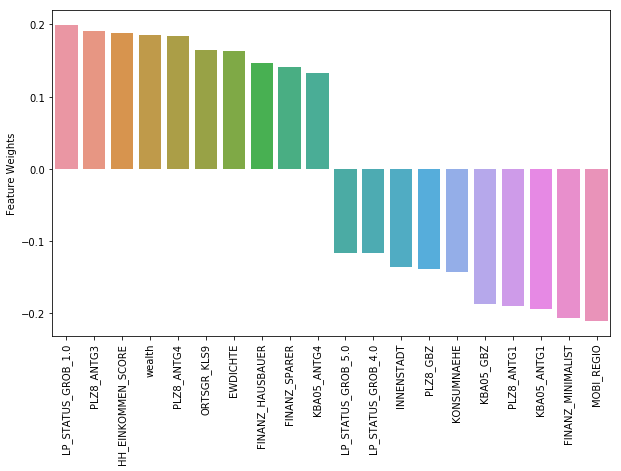

In [71]:
# Map weights for the first principal component to corresponding feature names
sort_pca_weight(0, 10)

Labels are: ['ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER', 'ZABEOTYP_3', 'SEMIO_ERL', 'SEMIO_LUST', 'RETOURTYP_BK_S', 'W_KEIT_KIND_HH', 'FINANZ_HAUSBAUER', 'CJT_GESAMTTYP_2.0', 'FINANZTYP_5', 'SEMIO_RAT', 'ONLINE_AFFINITAET', 'SEMIO_KULT', 'FINANZ_ANLEGER', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 'SEMIO_REL', 'decade']


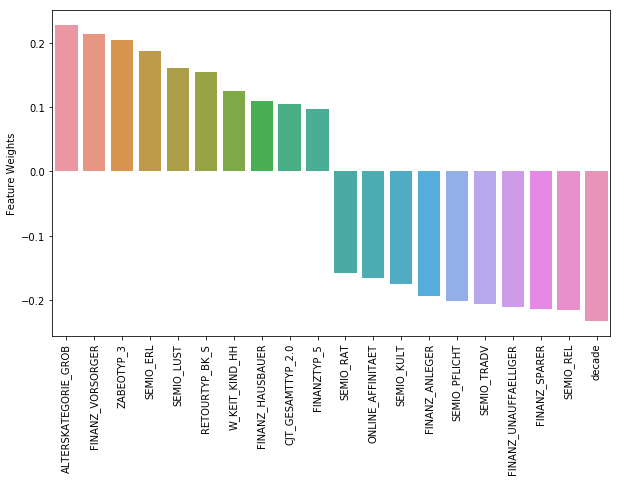

In [72]:
# Map weights for the second principal component to corresponding feature names
sort_pca_weight(1, 10)

Labels are: ['SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT', 'FINANZTYP_5', 'FINANZ_MINIMALIST', 'SHOPPER_TYP_0.0', 'ZABEOTYP_1', 'SEMIO_REL', 'RETOURTYP_BK_S', 'FINANZ_SPARER', 'SHOPPER_TYP_2.0', 'FINANZTYP_1', 'FINANZ_ANLEGER', 'SEMIO_RAT', 'SEMIO_ERL', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'ANREDE_KZ']


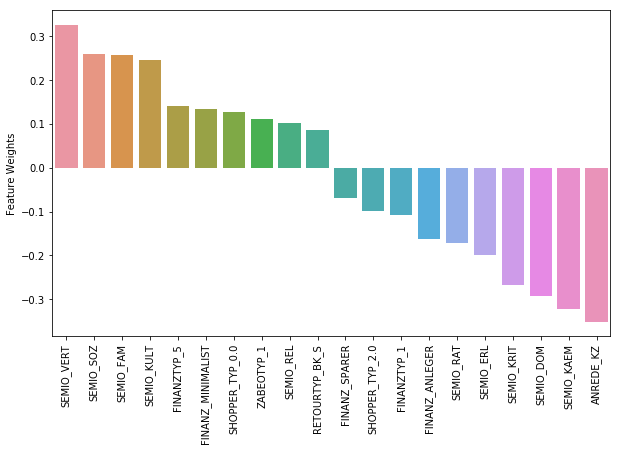

In [111]:
# Map weights for the third principal component to corresponding feature names
sort_pca_weight(2, 10)

---
### Discussion 2.3: Interpret Principal Components
#### 1st component observations and interpreation
We can see on the plot that there are some features really opposed, such as:
* `LP_STATUS_GROB_1.0`: 'low-income earners' is opposed to level of 'Movement patterns' (`MOBI_REGIO`)
* `PLZ8_ANTG3`: Number of 6-10 family houses is opposed to level of 'finance low financial interest' (`FINANZ_MINIMALIST`)
* `HH_EINKOMMEN_SCORE`: level of 'Estimated household net income' is opposed to level of 'Number of 1-2 family houses' (`KBA05_ANTG1`)
* `wealth`: opposed to 'Number of 1-2 family houses' (`PLZ8_ANTG1`)
* `PLZ8_ANTG4`: 'Number of 10+ family houses' opposed to Number of buildings (`KBA05_GBZ`)
* `ORTSGR_KLS9`: 'Size of community' opposed to 'Distance from building to point of sale (PoS)' (`KONSUMNAEHE`)
* `EWDICHTE`: 'Density of households' opposed to 'Number of buildings' (`PLZ8_GBZ`)
* `FINANZ_HAUSBAUER`: 'home ownership' opposed to 'Distance to city center (downtown)' (`INNENSTADT`)
* `FINANZ_SPARER`: 'money-saver' opposed to 'houseowners' (`LP_STATUS_GROB_4.0`)
* `KBA05_ANTG4`: 'Number of 10+ family houses' opposed to 'top earners' (`LP_STATUS_GROB_5.0`)

==> Let's basically interpret this as "rich people vs. poor people, or with lower income".

#### 2nd component observations and interpreation
We can see on the plot that there are some features really opposed, such as:
* `ALTERSKATEGORIE_GROB`: Estimated age is opposed to `decade` (this makes sense !)
* `FINANZ_VORSORGER`: 'financial typology be prepared' is opposed to 'personality type religious' (`SEMIO_REL`)
* `SEMIO_ERL`: 'personality type event-oriented' is opposed to level of 'financial typology inconspicuous' (`FINANZ_UNAUFFAELLIGER`)
* `SEMIO_LUST`: 'personality type sensual-minded' is opposed to 'personality type traditional' (`SEMIO_TRADV`)
* `CJT_GESAMTTYP_2.0`: 'customer-Journey-Typology' is opposed to 'Online affinity' (`ONLINE_AFFINITAET`): of course, if people never buy online those 2 will be totally opposed
* `FINANZTYP_5`: 'financial type investor' opposed to 'personality type rational' (SEMIO_RAT). Makes sense, people too rational will not be likely to invest and take some risks.

#### 3rd component observations and interpretation
We can see on the plot that:
* `'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT'`  
are opposed to:
* `'SEMIO_RAT', 'SEMIO_ERL', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM'`

That make perfect sense are elements in the first category (counting positive) are related to ersonality typology and means respectively: _dreamful, socially-minded, family-minded, cultural-minded_ (let's say people open to others, basically) whereas the ones counting negative means respectively: _rational, event-oriented, critical-minded, dominant-minded, combative attitude_ (pragmatic and more, let's say, kind of selfish, self-oriented people).

* `'FINANZTYP_5', 'FINANZ_MINIMALIST', 'SHOPPER_TYP_0.0', 'ZABEOTYP_1', 'SEMIO_REL'`  
are opposed to:
* `'FINANZ_SPARER', 'SHOPPER_TYP_2.0', 'FINANZTYP_1', 'FINANZ_ANLEGER'`

Here, it is the level of financiel interest and type of investment that are opposed (_investor, level of low financial interest, external supplied hedonists, Energy consumption green, religious_) opposed to _level of money-saver, family-shopper, low financial interest, level of investor_

---

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [73]:
def get_kmeans_score(data, nb_clusters):
    '''
    Returns the absolute value of KMeans score
    :parameter data: dataset we want to fit kmeans to
    :parameter nb_clusters: (int) the number of clusters we want (i.e the 'K' value)
    :return: (float) SSE score for the KMeans model
    '''
    #instantiate KMeans, fit and compute a score
    kmeans = KMeans(n_clusters=nb_clusters, random_state=42)
    model = kmeans.fit(data)
    return np.abs(model.score(data))

In [79]:
# I would highly recommend not to run this cell as it might take few hours to run
scores = []
nb_clusters = list(range(1, 25))

# Over a number of different cluster counts...
for k in nb_clusters:
    # run k-means clustering on the data and compute the average within-cluster distances.
    scores.append(get_kmeans_score(X_pca, k))

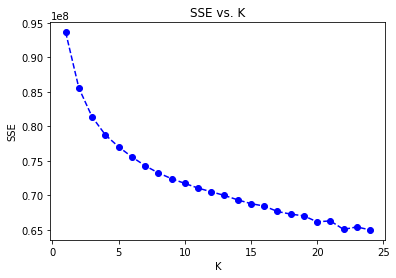

In [80]:
# Let's plot scores in order to decide the right number of centroids to take
plt.plot(nb_clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

***Observation:*** it seems that the Sum of Squared Errors value flattens with K around **22** so I will go with this value.

In [188]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=22, random_state=42)
predictions_general_pop = kmeans.fit_predict(X_pca)

---

### Discussion 3.1: Apply Clustering to General Population

The _elbow method_ has been used to find the best number of clusters for KMeans. You can see on above picture that the best value is **k=22** because starting from here the average distance within cluster almost flattens.  
So here we are with our 22 clusters from General Population, which is still quite a lot.

---

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [189]:
# Load in the customer demographics data.
customers = pd.read_csv(RAW_CUSTOMERS_FILENAME, sep=';')
customers.shape

(191652, 85)

In [235]:
# Apply preprocessing, feature transformation onto the customer data
customers_clean = clean_data(customers, feat_info, treshold=8, use_treshold=True)
print(customers_clean.shape)

(135799, 128)


***Note:*** there is something to deal with here as we expected 129 columns/features and the clean_data gave only 128. We need to analyze why. First intuition is that one column which has been one-hot encoded was missing a value in the customers dataset so the column has not been created by `get_dummies` method. Let's ensure that and create the column if I am right.

In [236]:
[x for x in azdias_clean.columns if x not in customers_clean.columns]

['GEBAEUDETYP_5.0']

In [237]:
customers['GEBAEUDETYP'].value_counts()

1.0    95145
3.0    23655
8.0    20475
2.0     2057
4.0      251
6.0      142
Name: GEBAEUDETYP, dtype: int64

In [238]:
azdias['GEBAEUDETYP'].value_counts()

1.0    460465
3.0    178668
8.0    152476
2.0      4935
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64

This is it, one value does not exist in the customers dataset, it does not matter, let's create the `'GEBAEUDETYP_5.0'` column in the `customers_clean` dataset.

In [239]:
customers_clean['GEBAEUDETYP_5.0'] = 0

In [240]:
customers_imputed = feat_imp.transform(customers_clean)
customers_scaled = feat_scaler.transform(customers_imputed)
print(customers_imputed.shape)
print(customers_scaled.shape)

(135799, 129)
(135799, 129)


In [241]:
# Apply PCA + clustering onto the customer data, obtain cluster predictions for the
# customer demographics data.
X_pca_cust = pca.transform(customers_scaled)
predictions_customers_pop = kmeans.predict(X_pca_cust)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [242]:
rows_pop = azdias.shape[0]
rows_pop_sb1 = azdias_pp_subset1.shape[0]
rows_pop_sb2 = azdias_pp_subset2.shape[0]
rows_cust = customers.shape[0]
rows_cust_sb = customers_clean.shape[0]
diff_cust = rows_cust-rows_cust_sb

print("Demographic subset with few or no missing values contains {} rows whereas the other subset contains {} ({:.2f} % of the total)"
      .format(rows_pop_sb1, rows_pop_sb2, 100 * (rows_pop_sb2/rows_pop)))
print("Customers subset with few or no missing values contains {} rows whereas the other subset contains {} ({:.2f} % of the total)"
      .format(rows_cust_sb, diff_cust, 100 * (diff_cust/rows_cust)))

Demographic subset with few or no missing values contains 771701 rows whereas the other subset contains 119520 (13.41 % of the total)
Customers subset with few or no missing values contains 135799 rows whereas the other subset contains 55853 (29.14 % of the total)


#### Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population
For that I will build a new dataframe which will contains all predictions, then group by cluster id and then compute proportion for both 'general population' and 'customers' dataset with respect to initial dataset size.  
Cells below are the details to achieve that. In the end, there is a coherence control that everything worked as expected by summing all proportions for both origin and check that it is 100%

In [302]:
df_pop = pd.DataFrame(predictions_general_pop)
df_pop["from"] = 'general'
df_cust = pd.DataFrame(predictions_customers_pop)
df_cust["from"] = 'customer'
df_pop_cust = pd.concat([df_pop, df_cust])
df_pop_cust.columns = ['cluster_id', 'origin']
df_pop_cust.head()

,cluster_id,origin
0,9,general
1,16,general
2,4,general
3,5,general
4,16,general


In [303]:
df_pop_cust = pd.crosstab([df_pop_cust.cluster_id, df_pop_cust.origin], df_pop_cust.origin, margins=False).reset_index()
df_pop_cust['proportion'] = df_pop_cust.apply(
    lambda x: np.round(100 * (x['customer']/rows_cust), 2) if x['origin'] == 'customer' 
    else np.round(100 * (x['general']/rows_pop), 2) if x['origin'] == 'general' else x, axis=1)
df_pop_cust = df_pop_cust.drop(['customer', 'general'], axis=1)
df_pop_cust.head(8)

origin,cluster_id,origin,proportion
0,0,customer,0.67
1,0,general,3.14
2,1,customer,5.42
3,1,general,4.60
4,2,general,1.58
5,3,customer,0.14
6,3,general,2.52
7,4,customer,0.14


In [304]:
# Do not forget to add the subset of 'missing value' proportion computed earlier as a new cluster with id 22
df_pop_cust = df_pop_cust.append({
    'cluster_id': 22,
    'origin': 'general',
    'proportion': np.round(100 * (rows_pop_sb2/rows_pop), 2)
    }, ignore_index=True)
df_pop_cust = df_pop_cust.append({
    'cluster_id': 22,
    'origin': 'customer',
    'proportion': np.round(100 * (diff_cust/rows_cust), 2)
    }, ignore_index=True)

In [305]:
df_pop_cust.tail(5)

origin,cluster_id,origin,proportion
40,20,general,0.00
41,21,customer,2.63
42,21,general,2.21
43,22,general,13.41
44,22,customer,29.14


In [306]:
print("Sanity check proportion 'general' should sum to 100%, we have: {:.2f}%".
      format(df_pop_cust[df_pop_cust['origin'] == 'general'].proportion.sum()))
print("Sanity check proportion 'customers' should sum to 100%, we have: {:.2f}%".
      format(df_pop_cust[df_pop_cust['origin'] == 'customer'].proportion.sum()))

Sanity check proportion 'general' should sum to 100%, we have: 99.99%
Sanity check proportion 'customers' should sum to 100%, we have: 100.00%


OK, now let's display that on same plot to observe difference:

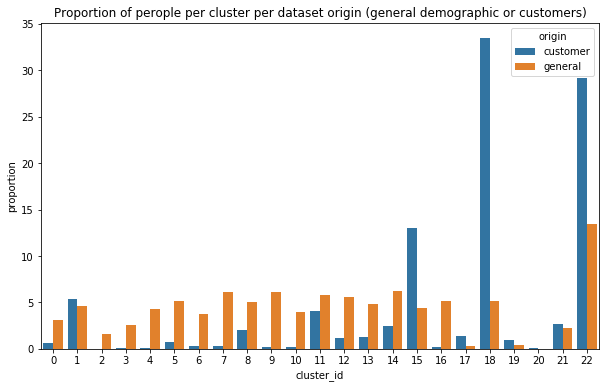

In [307]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title("Proportion of perople per cluster per dataset origin (general demographic or customers)")
sns.barplot(x='cluster_id', y='proportion', hue='origin', data=df_pop_cust)
plt.show()

In order to display the difference between `customers` and `general` cluster proportions, I will use a trick and put all `general` as negative values then groupby the dataframe per cluster_id and sum the proportion. It will then give me just the difference per cluster.

In [308]:
df_pop_cust['proportion'] = df_pop_cust.apply(lambda x: 0-x['proportion'] if x['origin'] == 'general' else x['proportion'], axis=1)

In [309]:
df_pop_cust.head()

origin,cluster_id,origin,proportion
0,0,customer,0.67
1,0,general,-3.14
2,1,customer,5.42
3,1,general,-4.60
4,2,general,-1.58


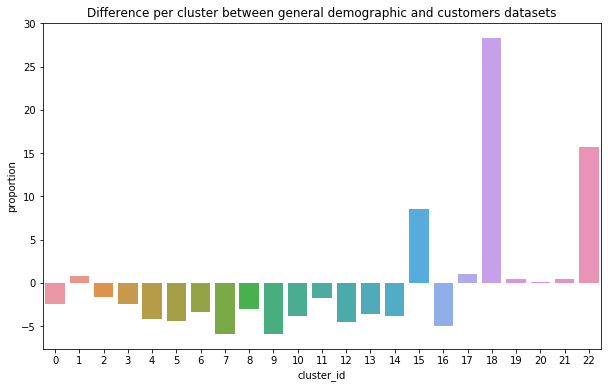

In [310]:
diff = df_pop_cust.groupby('cluster_id').proportion.sum().reset_index()
fig, ax = plt.subplots(figsize = (10,6))
ax.set_title("Difference per cluster between general demographic and customers datasets")
sns.barplot(x='cluster_id', y='proportion', data=diff)
plt.show()

#### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population ?
#### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population ?
We can see in the plot above that 2 clusters (if we forget our additional one which corresponds to rows with a lot of missing values) have the highest positive difference: cluster 15 and cluster 18. The highest negative are in cluster 7 and 9. 
Let's identify the people inside.

In [330]:
def retrieve_original_space_data(cluster_id):
    return feat_scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[cluster_id]))

In [331]:
center15_original_space = retrieve_original_space_data(15)
center18_original_space = retrieve_original_space_data(18)
center7_original_space = retrieve_original_space_data(7)
center9_original_space = retrieve_original_space_data(9)

In [334]:
centers_data = [center15_original_space, center18_original_space, center7_original_space, center9_original_space]
centers_df = pd.DataFrame(centers_data)
centers_df.columns = azdias_clean.columns
centers_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,movement,decade,wealth,lifestage,neighborhood,new_building
0,3.480751,1.955576,4.251359,1.411307,4.438740,1.901320,1.940927,2.458064,0.998722,2.056988,...,0.095152,0.037801,0.028968,0.009767,0.998722,3.334675,1.993789,3.670204,3.366258,-0.001568
1,3.345030,1.037155,4.823049,1.514873,4.442286,1.401441,1.957699,1.974487,1.006028,2.039736,...,0.093660,0.044915,0.033780,0.015282,1.006028,3.426806,2.066169,3.705748,3.293163,-0.004519
2,1.854671,0.958954,1.747860,4.563370,1.920223,3.660023,3.934459,3.662237,0.107846,2.338015,...,0.110389,0.132394,0.317213,0.340321,0.107846,5.826694,4.413705,1.889876,3.616073,0.001678
3,1.613523,2.001359,1.128113,4.437006,2.178836,4.288398,3.860741,4.155899,0.025475,2.138529,...,0.145374,0.140332,0.337152,0.255299,0.025475,5.620903,4.329121,2.158954,3.457704,-0.000664


In [336]:
# Let's also display some others features that are truncated above
# Those features are not picked randomly but provide from PCA interpretation earlier in the project.
centers_df[['MOBI_REGIO', 'HH_EINKOMMEN_SCORE', 'SEMIO_REL', 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT']].head()

,MOBI_REGIO,HH_EINKOMMEN_SCORE,SEMIO_REL,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT
0,4.202172,2.572634,2.081906,3.109085,3.180004,2.029044,1.975210
1,4.219728,2.363536,3.755387,6.272608,4.937228,4.797161,4.961930
2,1.722480,5.549496,6.218499,6.079047,6.693613,6.755604,6.843033
3,2.065121,5.653729,5.586090,2.217099,3.001035,3.997289,4.290874


---

### Discussion 3.3: Compare Customer Data to Demographics Data
We can see in the above display that there is clear opposition on some columns between the 2 first lines and the 2 last ones:
* `FINANZ_MINIMALIST` (the lower the value the less interest in finance): more than 4 in popular vs. less than 2 in unpopular
* `FINANZ_SPARER` (money saver): it is the opposite: less than 2 vs. more than 4.
* `FINANZ_ANLEGER` (investor): in popular segment, people are very likely to invest.
* `GREEN_AVANTGARDE`: is 1 in popular segment, near 0 in unpopular segment.
* `movement`: is 1 in popular segment, near 0 in unpopular segment.
* `decade`: people in popular segment are more from the 60s (value 3) whereas they are more from the 90s in unpopular (value 6)
* `wealth`: wealth is 2 ('Prosperous Households') in popular segment vs. 4 in unpopular => company should target wealthy people, obviously
* `lifestage`: people which belong to 'Families With School Age Children' category are in popular vs. 'Young Couples With Children'

Based on this clusters analysis we can say that people in popular segment:
* are **wealthy**
* are **from the 60s**
* have **interest in finance**, likely to invest and **have money** ('very high income' to 'high income' in `HH_EINKOMMEN_SCORE`)
* don't move a lot (`MOBI_REGIO` =~ 4)
* are more religious (`SEMIO_REL`)

**Those are the people this company should target in priority.**

---

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.